In [1]:
import pandas as pd
import numpy as np
import copy

# import matplotlib.pyplot as plt
# import seaborn as sns
# # sns.set()

# custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
# sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from survivors import visualize as vis
import survivors.datasets as ds

In [2]:
import survivors.constants as cnt

### Построение непараметрических моделей

In [85]:
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()

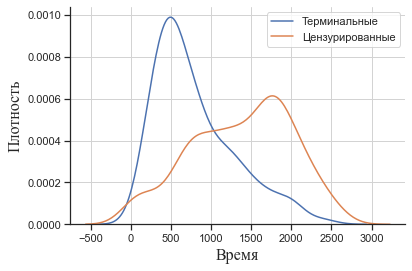

In [101]:
import matplotlib.pyplot as plt

# custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
# sns.set_theme(style="ticks", rc=custom_params)

sns.kdeplot(y[y["cens"] == 1]["time"], label="Терминальные")
sns.kdeplot(y[y["cens"] == 0]["time"], label="Цензурированные")
plt.xlabel("Время", fontsize=16, fontname="Times New Roman")
plt.ylabel("Плотность", fontsize=16, fontname="Times New Roman")
plt.legend()

In [4]:
bins = cnt.get_bins(time=y["time"], cens=y["cens"])

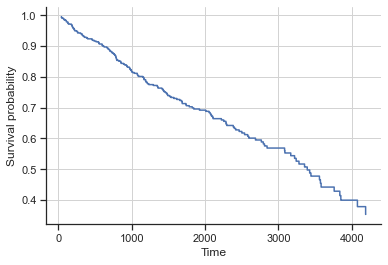

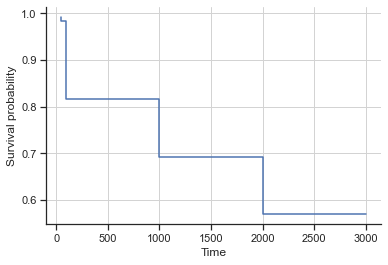

In [5]:
from survivors.external import KaplanMeier

# def plot_surival_function(sf, bins, title=""):
#     plt.step(bins, sf)
#     plt.xlabel('Time')
#     plt.ylabel('Survival probability')
#     plt.title(title)
#     plt.show()

km = KaplanMeier()
km.fit(durations=y["time"], right_censor=y["cens"])
sf_km = km.survival_function_at_times(times=bins)
vis.plot_survival_function(sf_km, bins)

bins_short = [50, 100, 1000, 2000, 3000]
sf_km_short = km.survival_function_at_times(times=bins_short)
vis.plot_survival_function(sf_km_short, bins_short)

In [6]:
bins.shape

(4151,)

### Построение индивидуальных прогнозов (деревья выживаемости)

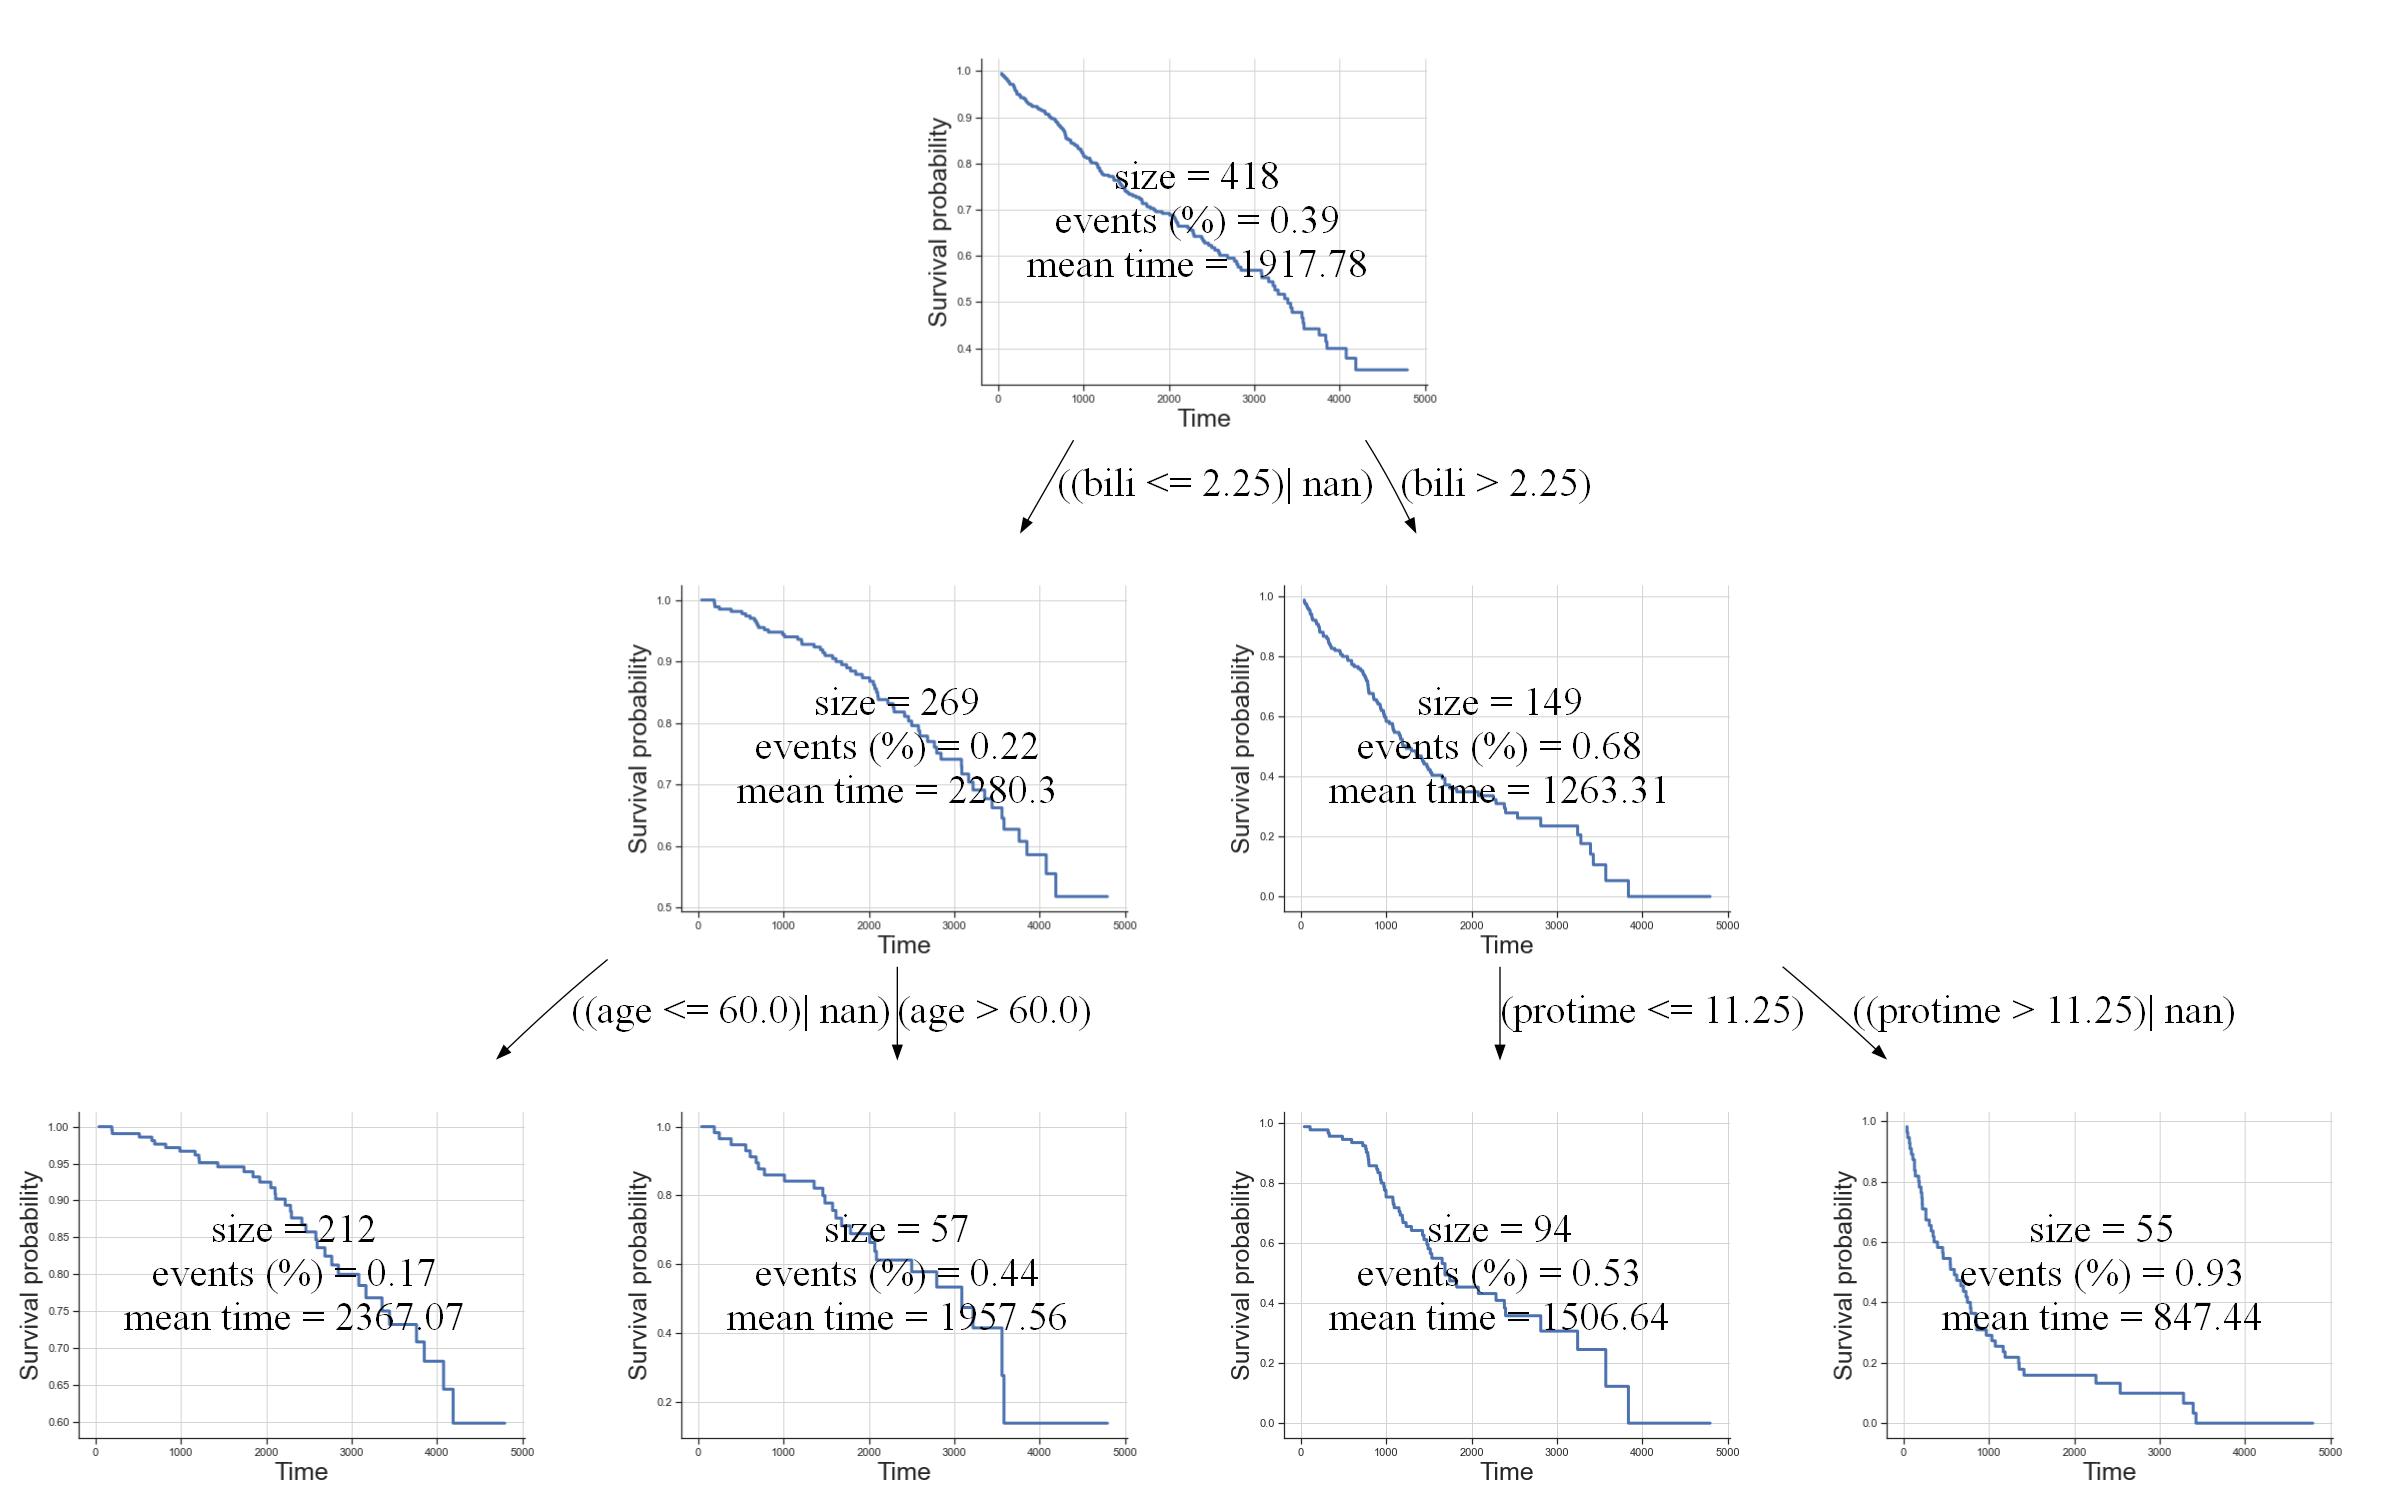

In [57]:
from survivors.tree import CRAID

# Создание дерева выживаемости
cr = CRAID(criterion='logrank', depth=2, min_samples_leaf=0.1, signif=0.05,
           categ=categ, leaf_model="base")

# Обучение дерева
cr.fit(X, y)

# Прогноз функции выживания для всех наблюдений выборки X
sf_cr = cr.predict_at_times(X, bins=bins, mode="surv")
chf_cr = cr.predict_at_times(X, bins=bins, mode="hazard")

# Визуализация структуры дерева
cr.visualize(target=cnt.TIME_NAME, mode="surv")

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['sex'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:990: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1163: ConvergenceWarning: Column sex has high sample correlation with the duration column.

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['sex'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:990: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1163: ConvergenceWarning: Column stage has high sample correlation with the duration colum

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:990: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1163: ConvergenceWarning: Column stage has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1163: ConvergenceWarning: Column sex has hi

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['ascites'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['edema', 'ascites'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\life

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['sex', 'edema', 'ascites', 'spiders'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:990: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column hepato have very low varia

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['edema'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column ascites have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['cens'].astype(bool)
>>> print(df.loc[events, 'ascites'].var())
>>> print(df.loc[~events, 'ascites'].var())

A very low variance 

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['ascites'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['ascites'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\uti

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['edema'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column ascites have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['cens'].astype(bool)
>>> print(df.loc[events, 'ascites'].var())
>>> print(df.loc[~events, 'ascites'].var())

A very low variance 

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['sex', 'edema', 'ascites', 'spiders'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:990: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1163: ConvergenceWarning: Column sex has high sample correl

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['ascites'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:990: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column edema have very low variance when conditioned on deat

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:990: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1163: ConvergenceWarning: Column stage has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1163: ConvergenceWarning: Column sex has hi

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:990: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1163: ConvergenceWarning: Column sex has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1163: ConvergenceWarning: Column edema has hi

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['sex', 'ascites'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:990: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column edema have very low variance when conditioned 

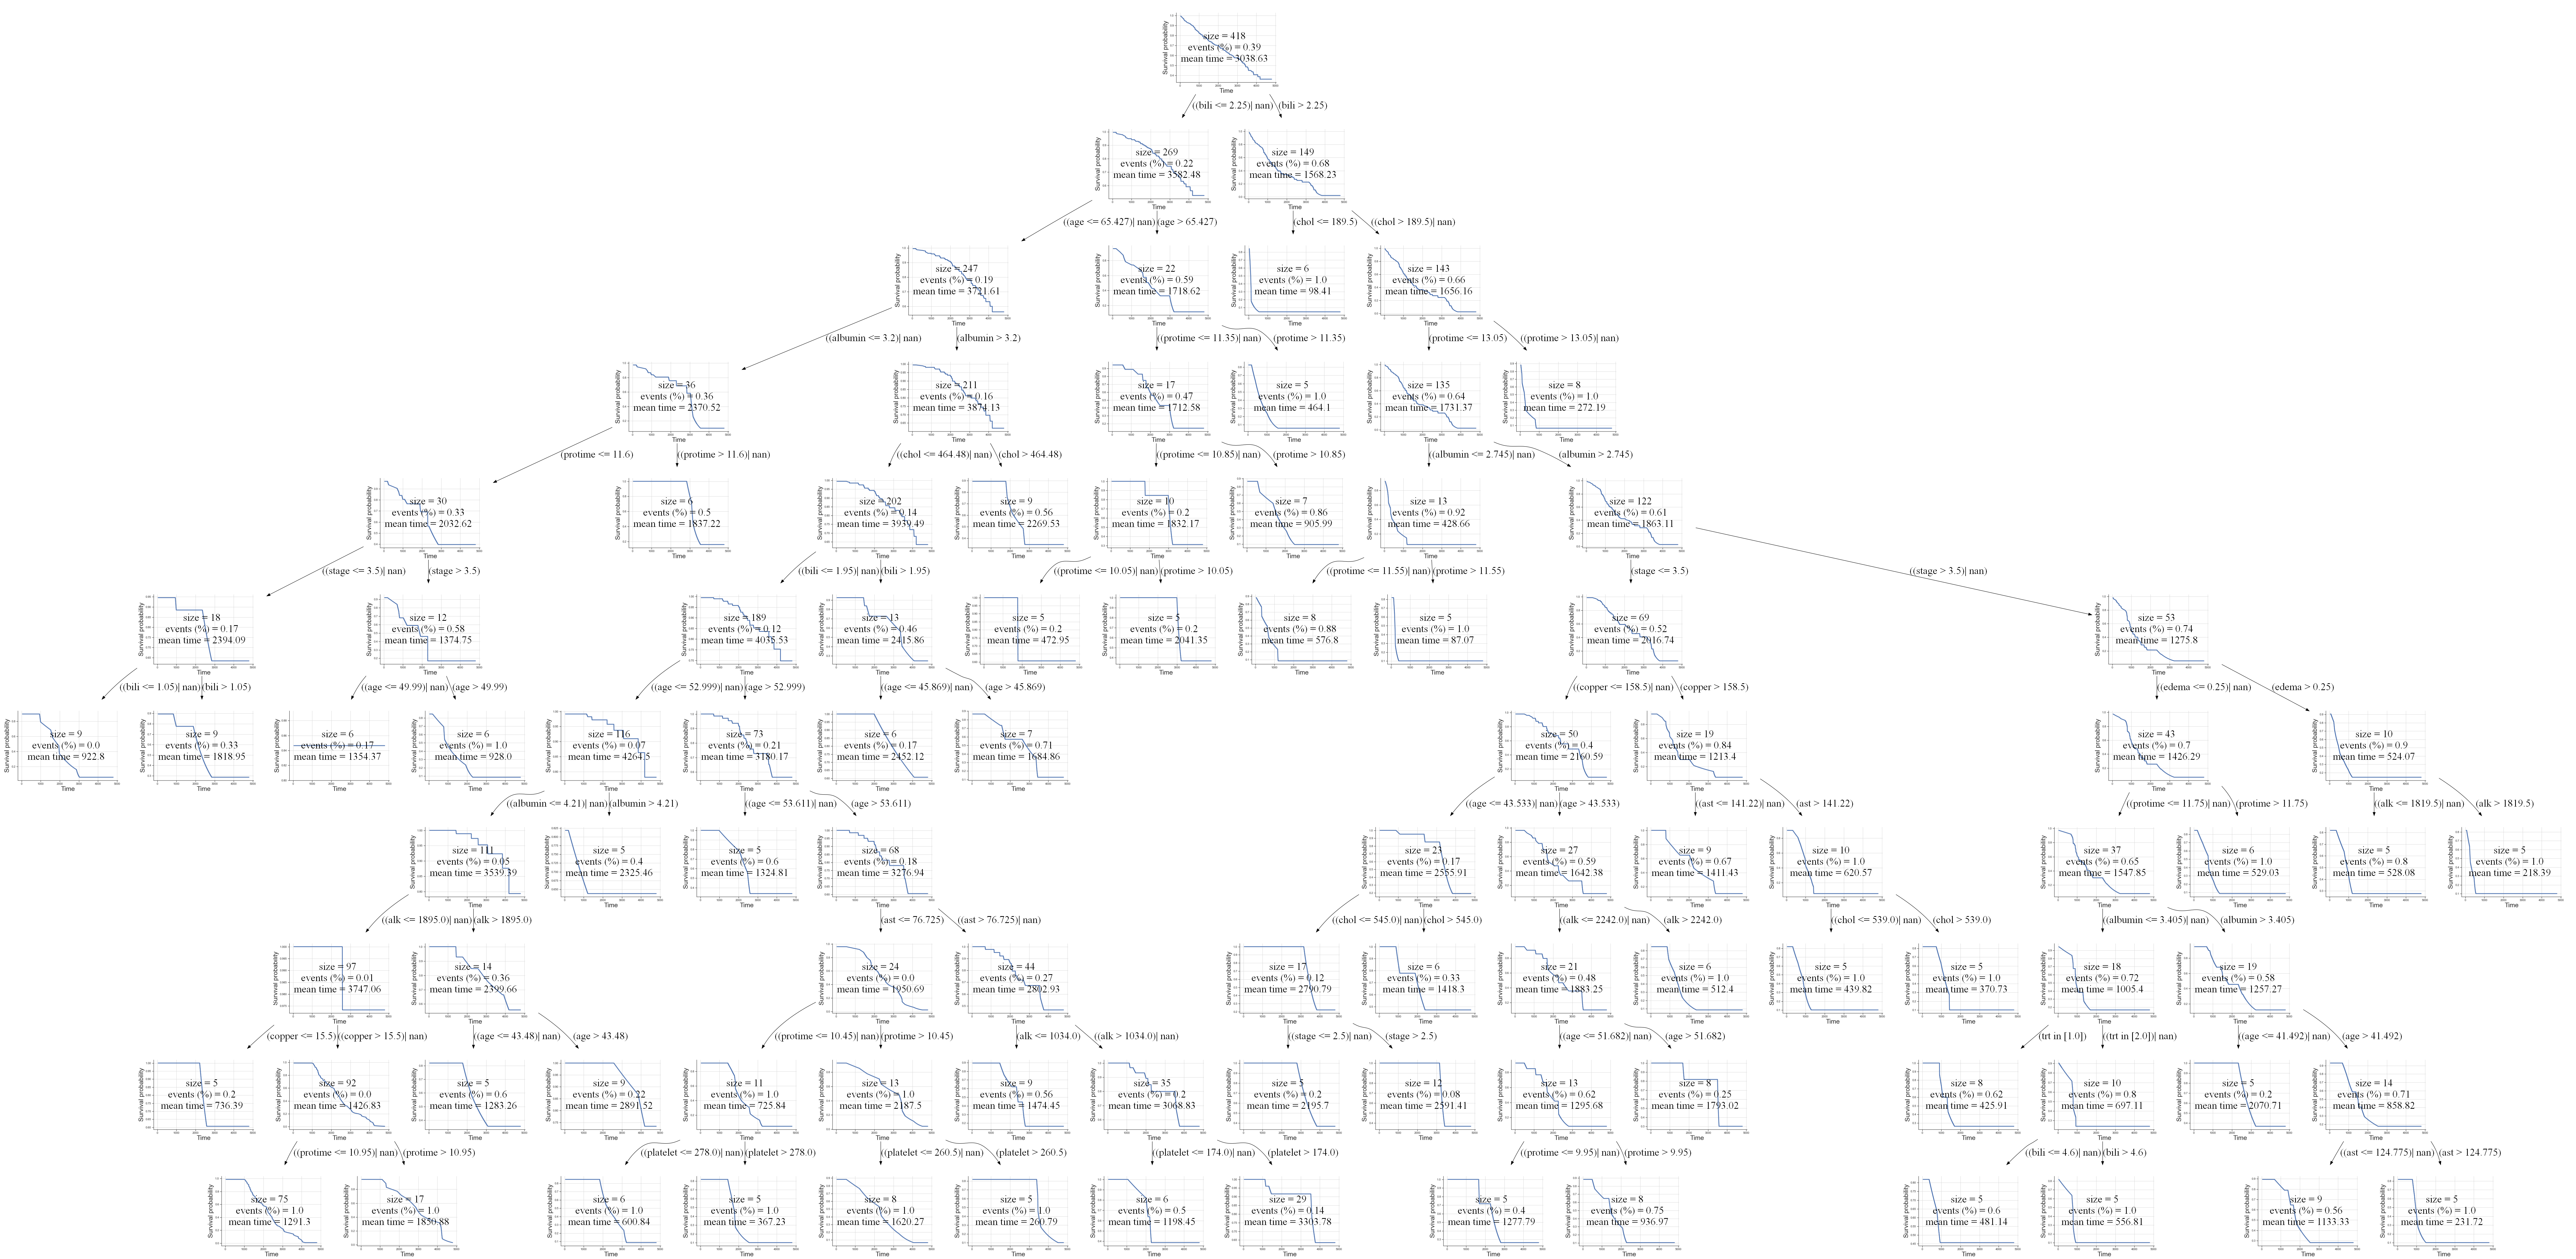

In [10]:
from survivors.tree import CRAID

# Создание дерева выживаемости
cr = CRAID(criterion='logrank', depth=10, min_samples_leaf=0.01, signif=0.2,
           categ=categ, leaf_model="CoxPH", leaf_penalizer=10, leaf_except_stop=False)

# Обучение дерева
cr.fit(X, y)

# Прогноз функции выживания для всех наблюдений выборки X
sf_cr = cr.predict_at_times(X, bins=bins, mode="surv")
chf_cr = cr.predict_at_times(X, bins=bins, mode="hazard")

# Визуализация структуры дерева
cr.visualize(target=cnt.TIME_NAME, mode="surv")

In [11]:
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter, CoxPHFitter

X_ = X.copy()
X_[cnt.TIME_NAME] = y[cnt.TIME_NAME]
X_[cnt.CENS_NAME] = y[cnt.CENS_NAME]
X_ = X_.fillna(0).replace(np.nan, 0)

In [15]:
from survivors.external import WeibullAFT

w = WeibullAFT()
w.fit(X_)
w.predict_feature(X=None, feature_name=cnt.CENS_NAME)

array([0.38516746])

In [16]:
round(w.predict_feature(X=None, feature_name=cnt.CENS_NAME)[0], 2)

0.39

In [26]:
w = CoxPHFitter()
w.fit(X_, cnt.TIME_NAME, event_col=cnt.CENS_NAME, step_size=0.2)

TypeError: CoxPHFitter.fit() got an unexpected keyword argument 'step_size'

In [18]:
w.predict_cumulative_hazard(w._central_values, times=bins)

,baseline
41.0,0.000705
42.0,0.000731
43.0,0.000757
44.0,0.000783
45.0,0.000809
...,...
4187.0,0.670501
4188.0,0.670739
4189.0,0.670976
4190.0,0.671213


In [19]:
t = w.predict_survival_function(w._central_values, times=bins).to_numpy().T

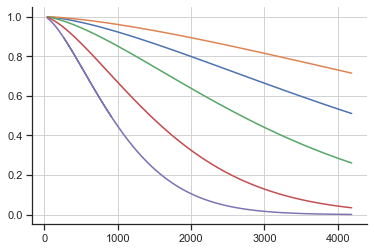

In [24]:
import matplotlib.pyplot as plt

plt.step(bins, t[0])
plt.step(bins, t[0]**0.5)
plt.step(bins, t[0]**2)
plt.step(bins, t[0]**5)
plt.step(bins, t[0]**10)

In [18]:
w.__dict__

{'alpha': 0.05,
 '_class_name': 'WeibullAFTFitter',
 '_label': None,
 '_censoring_type': <CensoringType.RIGHT: 'right'>,
 'penalizer': 0.0,
 'l1_ratio': 0.0,
 '_fitted_parameter_names': ['lambda_', 'rho_'],
 'fit_intercept': True,
 'model_ancillary': False,
 'duration_col': 'time',
 'event_col': 'cens',
 'entry_col': None,
 'weights_col': None,
 'durations': 0       400.0
 1      4500.0
 2      1012.0
 3      1925.0
 4      1504.0
         ...  
 413     681.0
 414    1103.0
 415    1055.0
 416     691.0
 417     976.0
 Name: time, Length: 418, dtype: float64,
 '_time_fit_was_called': '2024-02-21 07:05:20 UTC',
 '_n_examples': 418,
 'robust': False,
 'timeline': array([  41.,   43.,   51.,   71.,   77.,   94.,  110.,  111.,  130.,
         131.,  140.,  179.,  186.,  191.,  193.,  198.,  207.,  216.,
         221.,  223.,  249.,  264.,  304.,  321.,  326.,  334.,  348.,
         359.,  388.,  400.,  460.,  466.,  489.,  515.,  533.,  549.,
         552.,  559.,  597.,  611.,  617.,  62

In [8]:
chf_cr.shape

(418, 4151)

In [8]:
print(cr.predict(X, target=cnt.TIME_NAME)[0])
print(cr.predict(X, target=cnt.CENS_NAME)[0])
print(cr.predict(X, target="depth")[0])

847.4363403320312
0.9272727272727272
2.0


In [30]:
print(cr.predict(X, target=cnt.TIME_NAME)[0])
print(cr.predict(X, target=cnt.CENS_NAME)[0])
print(cr.predict(X, target="depth")[0])

90.067364095508
1.0
5.0


In [32]:
y[0]

(True, 400.)

In [31]:
pred_time = cr.predict(X, target=cnt.TIME_NAME)
print(pred_time[0])
pred_prob = cr.predict(X, target=cnt.CENS_NAME)
print(pred_prob[0])
pred_depth = cr.predict(X, target="depth")
print(pred_depth[0])
# pred_size = cr.predict(X, target="size")

# for f in features:
#     pred = cr.predict(X, target=f)
#     print(f, pred[0], X.iloc[0][f])

90.067364095508
1.0
5.0


### Построение ансамблей деревьев выживаемости

In [77]:
from survivors.ensemble import BootstrapCRAID

# Создание дерева выживаемости
bstr = BootstrapCRAID(n_estimators=10, size_sample=0.7, max_features=0.3, 
                      criterion='peto', depth=3, min_samples_leaf=0.01, categ=categ, leaf_model="base")

# Обучение дерева
bstr.fit(X, y)

# Прогноз функции выживания для всех наблюдений выборки X
sf_bstr = bstr.predict_at_times(X, bins=bins, mode="surv")

fitted: 10 models.


In [78]:
from survivors.ensemble import BoostingCRAID

# Создание дерева выживаемости
boost = BoostingCRAID(mode_wei='linear', n_estimators=10, size_sample=0.5, 
                      ens_metric_name='IBS_REMAIN', max_features=0.3, criterion='peto', depth=3,
                      min_samples_leaf=0.01, categ=categ, leaf_model="base")

# Обучение дерева
boost.fit(X, y)

# Прогноз функции выживания для всех наблюдений выборки X
sf_boost = boost.predict_at_times(X, bins=bins, mode="surv")

fitted: 10 models.


### Оценка качества прогнозов

In [82]:
m = metr.ibs_remain
for p in [sf_cr, sf_bstr, sf_boost]:
    mean_ibs = m(y, y, p, bins, axis=-1)
    print(mean_ibs.round(4))  # 0.071
ibs_by_obs = m(y, y, sf_bstr, bins, axis=0)
print(ibs_by_obs[:2].round(4), ibs_by_obs[-2:].round(4))  # [0.0138, 0.038, ..., 0.0000, 0.0007]
ibs_by_time = m(y, y, sf_bstr, bins, axis=1)
print(ibs_by_time[:2].round(4), ibs_by_time[-2:].round(4))   # [0.0047, 0.0037, ..., 0.0983, 0.3533]

0.1219
0.116
0.11
[0.0237 0.0379] [0.     0.0008]
[0.     0.0042] [0.1006 0.0857]


In [80]:
ibs_by_obs[:2].round(4)

array([0.0426, 0.0655])

In [74]:
ibs_by_time.shape

(4151,)

In [75]:
import seaborn as sns
custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

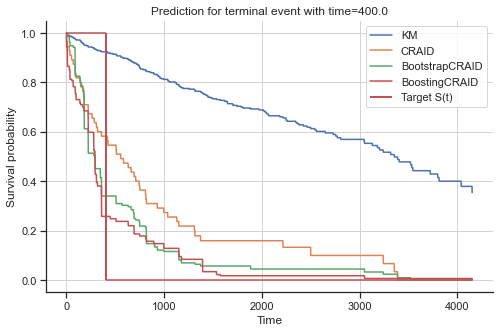

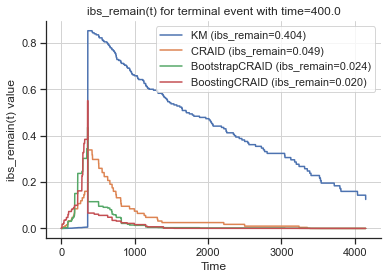

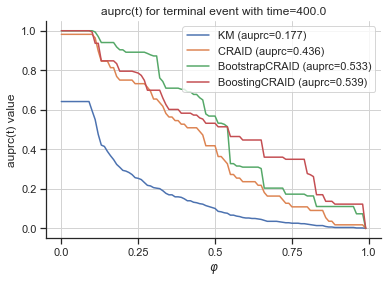

In [81]:
ind = 0

vis.plot_func_comparison(y[ind],
                     [sf_km, sf_cr[ind], sf_bstr[ind], sf_boost[ind]], 
                     ["KM", "CRAID", "BootstrapCRAID", "BoostingCRAID"])

vis.plot_metric_comparison(y[ind], 
                           [sf_km, sf_cr[ind], sf_bstr[ind], sf_boost[ind]], 
                           ["KM", "CRAID", "BootstrapCRAID", "BoostingCRAID"], bins, metr.ibs_remain)
vis.plot_metric_comparison(y[ind], 
                           [sf_km, sf_cr[ind], sf_bstr[ind], sf_boost[ind]], 
                           ["KM", "CRAID", "BootstrapCRAID", "BoostingCRAID"], bins, metr.auprc)